Compare bootstrap covariances estimated from several mock surveys generated with the TreePM256 box, and compare with those measured from the CLAMATO2017 data and also the covariances estimated from the ensemble of 80 mock surveys. This is to examine the effects of the overdensity in the mock volumes. Mock \# 031 is overdense, \#050 is average, \#024 is underdense.

(This is currently setup to run on NERSC)

In [1]:
import numpy as np
import time as time
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

# Read in bin edges
PiBin_fil = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'
PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)
PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data
# Convert bin boundaries from Mpc/h to Mpc
PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])

Cov_under = np.load('covar_MOSDEF_mock_024_n7200.npy')
Cov_ave = np.load('covar_MOSDEF_mock_050_n7200.npy')
Cov_ave2 = np.load('covar_MOSDEF_mock_009_n7200.npy')
Cov_over = np.load('covar_MOSDEF_mock_031_n7200.npy')

Cov_mosdef = np.load('covar_MOSDEF_v4.1_n7200.npy')
Cov_mocks = np.load('covar_rawmock80_mosdef_v4.1.npy')

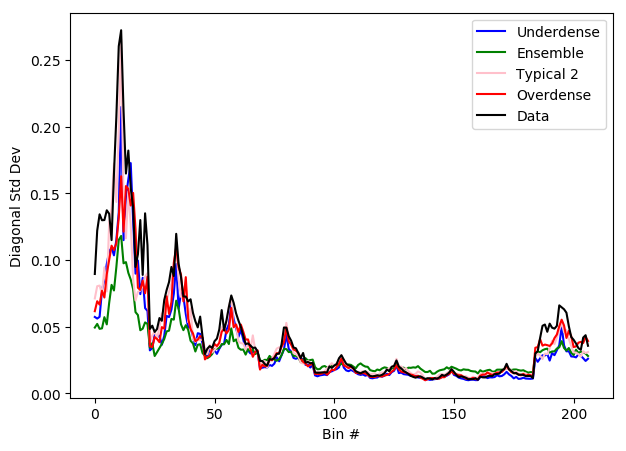

In [2]:
nbin1d = Cov_under.shape[0]

# Plot diagonals 
fig, ax = plt.subplots(figsize = (7,5))

err_under = np.sqrt(np.diagonal(Cov_under))
err_ave = np.sqrt(np.diagonal(Cov_ave))
err_ave2 = np.sqrt(np.diagonal(Cov_ave2))
err_over = np.sqrt(np.diagonal(Cov_over))
err_mosdef = np.sqrt(np.diagonal(Cov_mosdef))
err_mocks = np.sqrt(np.diagonal(Cov_mocks))

ax.plot(np.arange(nbin1d), err_under, color='blue', label='Underdense')
#ax.plot(np.arange(nbin1d), err_ave, color='green', label='Typical')
ax.plot(np.arange(nbin1d), err_mocks, color='green', label='Ensemble')
ax.plot(np.arange(nbin1d), err_ave2, color='pink', label='Typical 2')
ax.plot(np.arange(nbin1d), err_over, color='red', label='Overdense')
ax.plot(np.arange(nbin1d), err_mosdef, color='black', label='Data')

ax.set_xlabel('Bin #')

ax.set_ylabel('Diagonal Std Dev')
plt.legend()

plt.show()

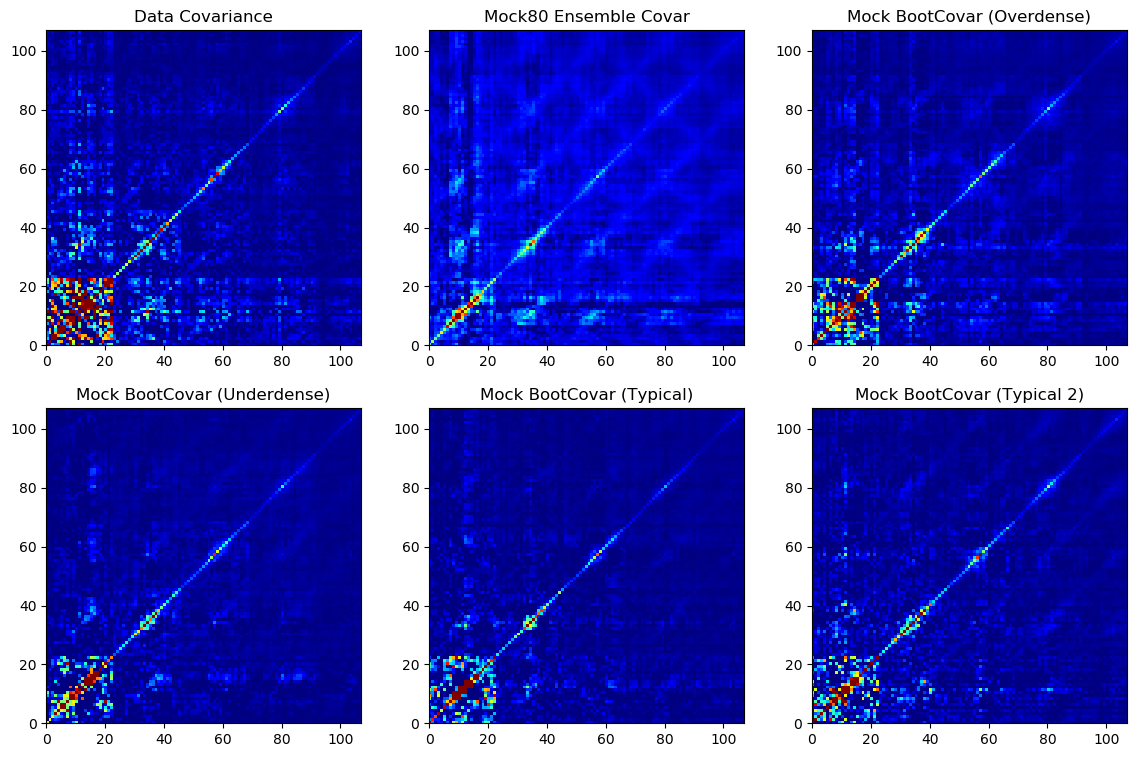

In [3]:
# Plot the covariance matrices for comparison
xmesh, ymesh = np.meshgrid(np.arange(nbin1d+1), np.arange(nbin1d+1))

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (14,9))

max_bin = 107

ax1.pcolormesh(xmesh, ymesh, Cov_mosdef, cmap='jet', vmin=0., vmax=0.005)
ax1.set_aspect('equal')
ax1.set_xlim(0, max_bin)
ax1.set_ylim(0,max_bin)
ax1.set_title('Data Covariance')


ax2.pcolormesh(xmesh, ymesh, Cov_mocks, cmap='jet', vmin=0., vmax=0.005)
ax2.set_aspect('equal')
ax2.set_xlim(0, max_bin)
ax2.set_ylim(0,max_bin)
ax2.set_title('Mock80 Ensemble Covar')

ax3.pcolormesh(xmesh, ymesh, Cov_over, cmap='jet', vmin=0., vmax=0.005)
ax3.set_aspect('equal')
ax3.set_xlim(0, max_bin)
ax3.set_ylim(0,max_bin)
ax3.set_title('Mock BootCovar (Overdense)')

ax4.pcolormesh(xmesh, ymesh, Cov_under, cmap='jet', vmin=0., vmax=0.005)
ax4.set_aspect('equal')
ax4.set_xlim(0, max_bin)
ax4.set_ylim(0,max_bin)
ax4.set_title('Mock BootCovar (Underdense)')

ax5.pcolormesh(xmesh, ymesh, Cov_ave, cmap='jet', vmin=0., vmax=0.005)
ax5.set_aspect('equal')
ax5.set_xlim(0, max_bin)
ax5.set_ylim(0,max_bin)
ax5.set_title('Mock BootCovar (Typical)')

ax6.pcolormesh(xmesh, ymesh, Cov_ave2, cmap='jet', vmin=0., vmax=0.005)
ax6.set_aspect('equal')
ax6.set_xlim(0, max_bin)
ax6.set_ylim(0,max_bin)
ax6.set_title('Mock BootCovar (Typical 2)')


plt.show()

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/matplotlib/colors.py:509: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


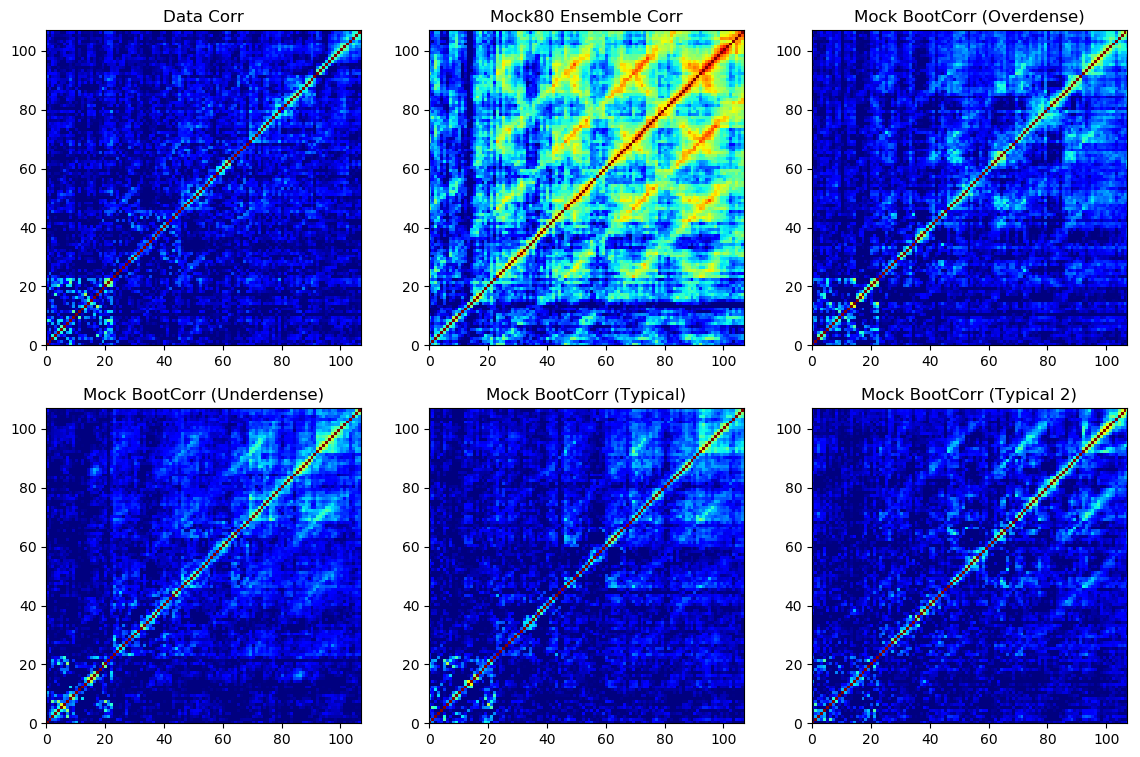

In [4]:
# Plot correlation functions

corr_mosdef = np.empty(Cov_mosdef.shape)
corr_over = np.empty(Cov_mosdef.shape)
corr_ave = np.empty(Cov_mosdef.shape)
corr_ave2 = np.empty(Cov_mosdef.shape)
corr_under = np.empty(Cov_mosdef.shape)
corr_mocks = np.empty(Cov_mosdef.shape)

for ii in np.arange(0,nbin1d-1):
    for jj in np.arange(0,nbin1d-1):
        corr_mosdef[ii,jj] = Cov_mosdef[ii,jj]/\
            np.sqrt(Cov_mosdef[ii,ii]*Cov_mosdef[jj,jj])
        corr_over[ii,jj] = Cov_over[ii,jj]/\
            np.sqrt(Cov_over[ii,ii]*Cov_over[jj,jj])
        corr_ave[ii,jj] = Cov_ave[ii,jj]/\
            np.sqrt(Cov_ave[ii,ii]*Cov_ave[jj,jj])
        corr_ave2[ii,jj] = Cov_ave2[ii,jj]/\
            np.sqrt(Cov_ave2[ii,ii]*Cov_ave2[jj,jj])
        corr_mocks[ii,jj] = Cov_mocks[ii,jj]/\
            np.sqrt(Cov_mocks[ii,ii]*Cov_mocks[jj,jj])
        corr_under[ii,jj] = Cov_under[ii,jj]/\
            np.sqrt(Cov_under[ii,ii]*Cov_under[jj,jj])

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (14,9))

max_bin = 107

ax1.pcolormesh(xmesh, ymesh, corr_mosdef, cmap='jet', vmin=0., vmax=1)
ax1.set_aspect('equal')
ax1.set_xlim(0, max_bin)
ax1.set_ylim(0,max_bin)
ax1.set_title('Data Corr')


ax2.pcolormesh(xmesh, ymesh, corr_mocks, cmap='jet', vmin=0., vmax=1)
ax2.set_aspect('equal')
ax2.set_xlim(0, max_bin)
ax2.set_ylim(0,max_bin)
ax2.set_title('Mock80 Ensemble Corr')

ax3.pcolormesh(xmesh, ymesh, corr_over, cmap='jet', vmin=0., vmax=1)
ax3.set_aspect('equal')
ax3.set_xlim(0, max_bin)
ax3.set_ylim(0,max_bin)
ax3.set_title('Mock BootCorr (Overdense)')

ax4.pcolormesh(xmesh, ymesh, corr_under, cmap='jet', vmin=0., vmax=1)
ax4.set_aspect('equal')
ax4.set_xlim(0, max_bin)
ax4.set_ylim(0,max_bin)
ax4.set_title('Mock BootCorr (Underdense)')

ax5.pcolormesh(xmesh, ymesh, corr_ave, cmap='jet', vmin=0., vmax=1)
ax5.set_aspect('equal')
ax5.set_xlim(0, max_bin)
ax5.set_ylim(0,max_bin)
ax5.set_title('Mock BootCorr (Typical)')

ax6.pcolormesh(xmesh, ymesh, corr_ave2, cmap='jet', vmin=0., vmax=1)
ax6.set_aspect('equal')
ax6.set_xlim(0, max_bin)
ax6.set_ylim(0,max_bin)
ax6.set_title('Mock BootCorr (Typical 2)')

plt.show()